# Scraping the information 

How?

- init session (gives you the cookies, the link to call later)
- init search with the right parameters
- get post response

## First request  (using a session)

After watching this video, I realized he uses a [Session](http://docs.python-requests.org/en/v1.0.4/user/advanced/). Let's try this.

In [1]:
import requests

In [2]:
s = requests.Session()

s.get('http://httpbin.org/cookies/set/sessioncookie/123456789')
r = s.get("http://httpbin.org/cookies")

print(r.text)
# '{"cookies": {"sessioncookie": "123456789"}}'

{
  "cookies": {
    "sessioncookie": "123456789"
  }
}



What if we do this with ameli?

In [144]:
s = requests.Session()

r = s.get('http://ameli-direct.ameli.fr')

r

<Response [200]>

## Getting the link for the second request

Getting the interesting link:

In [145]:
test_string = """<div id="centresite">
        <form action="/recherche-ceca2094e7dec344ca69beca17f092d2.html" method="post">
            <div class="choix-ps-es">
	<h2>Je recherche :</h2>"""

In [146]:
import re

In [147]:
p = re.compile('<form action="([\w\d/.-]+)" method="post">')

In [148]:
p.findall(test_string)

['/recherche-ceca2094e7dec344ca69beca17f092d2.html']

In [149]:
suburl = p.findall(r.text)[0]
suburl

u'/recherche-f37e8ccd9299ffd0512f6451db3292f5.html'

Good, we have an entry point into the system: the url we need to find.

It also looks like we have cookies!

In [150]:
r.cookies

<<class 'requests.cookies.RequestsCookieJar'>[Cookie(version=0, name='AmeliDirectPersist', value='359719223.20480.0000', port=None, port_specified=False, domain='ameli-direct.ameli.fr', domain_specified=False, domain_initial_dot=False, path='/', path_specified=True, secure=False, expires=None, discard=True, comment=None, comment_url=None, rest={}, rfc2109=False), Cookie(version=0, name='TS01b76c1f', value='0139dce0d28a9787802f747bcf08b6311fb05ccb4900b3de48d0dd0cef0edb971ad476c5f5d562a2319762d297a76ee857a78f2b93d3e5edc3568d2fa9675da7728b624e5a', port=None, port_specified=False, domain='ameli-direct.ameli.fr', domain_specified=False, domain_initial_dot=False, path='/', path_specified=True, secure=False, expires=None, discard=True, comment=None, comment_url=None, rest={}, rfc2109=False), Cookie(version=0, name='infosoins', value='qbm8t56jclinm2kcdduqs51dc1', port=None, port_specified=False, domain='ameli-direct.ameli.fr', domain_specified=False, domain_initial_dot=False, path='/', path_sp

## Making the second request 

Now, which request do we have to complete to finish this? We primarily need the sort of payload we want to ask the site for:

In [151]:
headers = {"User-Agent":"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.71 Safari/537.36"}

payload = {"type":"ps",
    "ps_profession":"ophtalmologiste",
    "ps_localisation":"75014"}

r = s.post("http://ameli-direct.ameli.fr" + suburl, params=payload,
          headers=headers)

In [152]:
r

<Response [200]>

In [153]:
r.text

u'<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd"><html xmlns="http://www.w3.org/1999/xhtml" xml:lang="fr">\n<head>\n\t<title>Annuaire sant\xe9 d\'ameli.fr : trouver un m\xe9decin, un h\xf4pital...</title>\n\t<meta name="description" content="L\u2019annuaire sant\xe9 de l\u2019Assurance Maladie pour trouver un m\xe9decin, un kin\xe9, un h\xf4pital\u2026 Tarifs \u2013 Horaires \u2013 Sp\xe9cialit\xe9s - Localisation" />\n\t<meta http-equiv="X-UA-Compatible" content="IE=edge">\n<meta http-equiv="Content-Type" content="text/html;charset=UTF-8" />\n<meta name="robots" content="noindex, nofollow" /><link href="/resources_ver/20150826115145/css/print_new.css" media="print" rel="stylesheet" type="text/css" />\n<link href="/resources_ver/20150826115145/css/jquery.qtip.css" media="screen" rel="stylesheet" type="text/css" />\n<link href="/resources_ver/20150826115145/css/styles_new.css" media="screen" rel="stylesheet" type=

Good, the first part of our work is done!

# The parsing 

Let's use beautiful soup to parse the document structure. There's a great documentation here: [http://www.crummy.com/software/BeautifulSoup/bs4/doc/](http://www.crummy.com/software/BeautifulSoup/bs4/doc/).

In [154]:
import bs4

In [155]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(r.text, 'html.parser')

BS gives us an easy access to most things from the structure.

In [156]:
soup.title

<title>Annuaire santé d'ameli.fr : trouver un médecin, un hôpital...</title>

We can find tags easily.

In [157]:
soup.findAll('strong')

[<strong>LE QUOY</strong>,
 <strong>SELLAM</strong>,
 <strong>BINN DEUTSCHER</strong>,
 <strong>CHAMOUNI</strong>,
 <strong>CHARLOT</strong>,
 <strong>COMMEAU</strong>,
 <strong>VAN WENT</strong>,
 <strong>THAN TRONG</strong>,
 <strong>BREZIN</strong>,
 <strong>SULMAN</strong>,
 <strong>FELLER</strong>,
 <strong>CHASSIGNOL</strong>,
 <strong>MEYER</strong>,
 <strong>KRETZ</strong>,
 <strong>PUECH</strong>,
 <strong>WERTHEL</strong>,
 <strong>MAGNANI</strong>,
 <strong>GIRARD DECIS</strong>,
 <strong>KELLER</strong>]

All doctors can be found like this:

In [158]:
doctors = soup.findAll('div', attrs={"class":"item-professionnel"})

A single doctor looks like this.

In [159]:
doctors[0]

<div class="item-professionnel"><div class="item-professionnel-inner"><span class="num">1</span><div class="nom_pictos"><h2><a href="/professionnels-de-sante/recherche-1/fiche-detaillee-B7c1ljU3MjKz-f37e8ccd9299ffd0512f6451db3292f5.html"><strong>LE QUOY</strong> OLIVIER</a></h2><div class="pictos"></div><div class="clear"></div></div><div class="clear"></div><div class="elements"><div class="item left"></div><div class="item right type_honoraires">Honoraires libres</div><div class="clear"></div><div class="item left tel">01 43 35 31 48</div><div class="item right convention"><a alt="Les médecins fixent librement leurs tarifs et peuvent donc pratiquer des dépassements d’honoraires avec tact et mesure. L’Assurance Maladie rembourse les consultations et actes réalisés par ces médecins sur la base des tarifs fixés dans la convention (tarifs applicables au médecin de secteur 2), le montant des éventuels dépassements d’honoraires reste à votre charge." class="infobulle" href="#">Conventionné

In [160]:
len(doctors)

20

Let's write a function that allows us to extract just the things we want.

In [161]:
block = doctors[0]

In [162]:
print(block.prettify())

<div class="item-professionnel">
 <div class="item-professionnel-inner">
  <span class="num">
   1
  </span>
  <div class="nom_pictos">
   <h2>
    <a href="/professionnels-de-sante/recherche-1/fiche-detaillee-B7c1ljU3MjKz-f37e8ccd9299ffd0512f6451db3292f5.html">
     <strong>
      LE QUOY
     </strong>
     OLIVIER
    </a>
   </h2>
   <div class="pictos">
   </div>
   <div class="clear">
   </div>
  </div>
  <div class="clear">
  </div>
  <div class="elements">
   <div class="item left">
   </div>
   <div class="item right type_honoraires">
    Honoraires libres
   </div>
   <div class="clear">
   </div>
   <div class="item left tel">
    01 43 35 31 48
   </div>
   <div class="item right convention">
    <a alt="Les médecins fixent librement leurs tarifs et peuvent donc pratiquer des dépassements d’honoraires avec tact et mesure. L’Assurance Maladie rembourse les consultations et actes réalisés par ces médecins sur la base des tarifs fixés dans la convention (tarifs applicables au 

In [163]:
block.find('h2').text

u'LE QUOY OLIVIER'

In [164]:
name = block.find('h2')

In [165]:
[text for text in name.stripped_strings]

[u'LE QUOY', u'OLIVIER']

In [166]:
adr = block.find("div", attrs={'class':"item left adresse"})
[text for text in adr.stripped_strings]

[u'29 RUE D ALESIA', u'75014 PARIS']

In [167]:
adr.get_text()

u'29 RUE D ALESIA75014 PARIS'

In [168]:
adr.get_text(' ')

u'29 RUE D ALESIA 75014 PARIS'

In [169]:
block.find("div", attrs={'class':"item left tel"}).text

u'01\xa043\xa035\xa031\xa048'

In [170]:
block.find("div", attrs={'class':"item right type_honoraires"}).text

u'Honoraires libres'

In [171]:
block.find("div", attrs={'class':"item right convention"}).text

u'Conventionn\xe9 secteur 2'

In [172]:
def extract_information(block):
    name = block.find('h2')
    address = block.find("div", attrs={'class':"item left adresse"})
    phone = block.find("div", attrs={'class':"item left tel"})
    prices = block.find("div", attrs={'class':"item right type_honoraires"})
    convention = block.find("div", attrs={'class':"item right convention"})
    return [item.get_text(' ') for item in [name, address, phone, prices, convention] if item is not None]

In [173]:
for doc in doctors:
    print(extract_information(doc))

[u'LE QUOY  OLIVIER', u'29 RUE D ALESIA 75014 PARIS', u'01\xa043\xa035\xa031\xa048', u'Honoraires libres', u'Conventionn\xe9 secteur 2']
[u'SELLAM  MICKAEL', u'CLINIQUE STE GENEVIEVE 29 RUE SARRETTE 75014 PARIS', u'Honoraires libres', u'Conventionn\xe9 secteur 2']
[u'BINN DEUTSCHER  SYLVIE', u'12 RUE DE LA TOMBE ISSOIRE 75014 PARIS', u'01\xa045\xa065\xa004\xa024', u'Honoraires libres', u'Conventionn\xe9 secteur 2']
[u'CHAMOUNI  HUBERT', u'95 AVENUE DU GAL LECLERC 75014 PARIS', u'Honoraires libres', u'Conventionn\xe9 secteur 2']
[u'CHARLOT  JEAN CLAUDE', u'228 BOULEVARD RASPAIL 75014 PARIS', u'01\xa043\xa022\xa042\xa033', u'Honoraires libres', u'Conventionn\xe9 secteur 2']
[u'COMMEAU  DOMINIQUE', u'22 RUE ERNEST CRESSON 75014 PARIS', u'01\xa045\xa041\xa073\xa063', u'Honoraires libres', u'Conventionn\xe9 secteur 2']
[u'VAN WENT  CHARLES', u'SELARL CHASSIGNOL VAN WENT 79 AVENUE DU GENERAL LECLERC 75014 PARIS', u'Honoraires libres', u'Conventionn\xe9 secteur 2']
[u'THAN TRONG  THONG', u'10

In [174]:
import pandas as pd

In [175]:
pd.DataFrame([extract_information(doc) for doc in doctors])

,0,1,2,3,4
0,LE QUOY OLIVIER,29 RUE D ALESIA 75014 PARIS,01 43 35 31 48,Honoraires libres,Conventionné secteur 2
1,SELLAM MICKAEL,CLINIQUE STE GENEVIEVE 29 RUE SARRETTE 75014 P...,Honoraires libres,Conventionné secteur 2,None
2,BINN DEUTSCHER SYLVIE,12 RUE DE LA TOMBE ISSOIRE 75014 PARIS,01 45 65 04 24,Honoraires libres,Conventionné secteur 2
3,CHAMOUNI HUBERT,95 AVENUE DU GAL LECLERC 75014 PARIS,Honoraires libres,Conventionné secteur 2,None
4,CHARLOT JEAN CLAUDE,228 BOULEVARD RASPAIL 75014 PARIS,01 43 22 42 33,Honoraires libres,Conventionné secteur 2
5,COMMEAU DOMINIQUE,22 RUE ERNEST CRESSON 75014 PARIS,01 45 41 73 63,Honoraires libres,Conventionné secteur 2
6,VAN WENT CHARLES,SELARL CHASSIGNOL VAN WENT 79 AVENUE DU GENERA...,Honoraires libres,Conventionné secteur 2,None
7,THAN TRONG THONG,10 RUE DAGUERRE 75014 PARIS,01 43 35 41 03,Honoraires libres,Conventionné secteur 2
8,CTRE SANTE MEDICAL DENTAIRE TISSERAND,CTRE SANTE MEDICAL DENTAIRE TISSERAND C A S VI...,None,None,None
9,BREZIN ANTOINE,HOPITAL COCHIN 27 RUE DU FBG SAINT JACQUES 750...,01 58 41 22 00,Honoraires libres,Conventionné secteur 2


# Extending the search: going for the 20 results per pages 

If there are more than 20 results for a given query, you only get them 20 by 20. The idea is to read this information from the first source and then perform the additional queries needed.

In [176]:
r.headers

{'content-encoding': 'gzip', 'transfer-encoding': 'chunked', 'expires': 'Mon, 19 Oct 2015 13:37:12 GMT', 'vary': 'Accept-Encoding', 'connection': 'close', 'pragma': 'no-cache', 'cache-control': 'no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'date': 'Mon, 19 Oct 2015 12:37:13 GMT', 'x-powered-by': 'Zend Framework 1.12.3', 'content-type': 'text/html; charset=UTF-8'}

In [177]:
r.request.headers

{'Connection': 'keep-alive', 'Cookie': 'TS01b76c1f=0139dce0d28a9787802f747bcf08b6311fb05ccb4900b3de48d0dd0cef0edb971ad476c5f5d562a2319762d297a76ee857a78f2b93d3e5edc3568d2fa9675da7728b624e5a; infosoins=qbm8t56jclinm2kcdduqs51dc1; AmeliDirectPersist=359719223.20480.0000', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.71 Safari/537.36'}

The URL containing the next doctors can be found in the request url.

In [178]:
r.url

u'http://ameli-direct.ameli.fr/professionnels-de-sante/recherche-1/liste-resultats-page-1-par_page-20-tri-aleatoire-f37e8ccd9299ffd0512f6451db3292f5.html'

We can also find the number of doctors found in the body of the previous request.

In [179]:
soup = BeautifulSoup(r.text)

In [180]:
tags = soup.find_all(name="h1")
tags

[<h1><img alt="Annuaire santé" class="logosite" src="/resources_ver/20150826115145/images/accueil/logo_amelidirect.png"/></h1>,
 <h1>26 résultats correspondent à votre recherche</h1>]

In [181]:
for tag in tags:
    if tag.string is not None:
        print(tag.string)

26 résultats correspondent à votre recherche


In [182]:
p = re.compile(u"(\d+) résultats correspondent à votre recherche")

In [183]:
for tag in tags:
    if tag.string is not None:
        print(p.findall(tag.string)[0])

26


In [236]:
def extract_number_of_doctors(soup):
    p = re.compile(u"(\d+) résultats correspondent à votre recherche")
    tags = soup.find_all(name="h1")
    for tag in tags:
        if tag.string is not None:
            return int(p.findall(tag.string)[0])
    return 0

In [237]:
extract_number_of_doctors(soup)

26

Now, we can automate the process of fetching pages. Here, we need to go until 26 doctors, so the number of pages to retrieve is 2.

In [189]:
import math

In [192]:
for pagenumber in range(1, int(math.ceil(extract_number_of_doctors(soup) / 20.)) + 1):
    print pagenumber

1
2


In [193]:
r.url

u'http://ameli-direct.ameli.fr/professionnels-de-sante/recherche-1/liste-resultats-page-1-par_page-20-tri-aleatoire-f37e8ccd9299ffd0512f6451db3292f5.html'

In [194]:
for pagenumber in range(1, int(math.ceil(extract_number_of_doctors(soup) / 20.)) + 1):
    print(r.url.replace("liste-resultats-page-1-par_page-20", "liste-resultats-page-{}-par_page-20").format(pagenumber))

http://ameli-direct.ameli.fr/professionnels-de-sante/recherche-1/liste-resultats-page-1-par_page-20-tri-aleatoire-f37e8ccd9299ffd0512f6451db3292f5.html
http://ameli-direct.ameli.fr/professionnels-de-sante/recherche-1/liste-resultats-page-2-par_page-20-tri-aleatoire-f37e8ccd9299ffd0512f6451db3292f5.html


In [195]:
r2 = s.post(r.url.replace("liste-resultats-page-1-par_page-20", "liste-resultats-page-{}-par_page-20").format(2))

In [196]:
r2

<Response [200]>

In [197]:
r2.text

u'<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd"><html xmlns="http://www.w3.org/1999/xhtml" xml:lang="fr">\n<head>\n\t<title>Annuaire sant\xe9 d\'ameli.fr : trouver un m\xe9decin, un h\xf4pital...</title>\n\t<meta name="description" content="L\u2019annuaire sant\xe9 de l\u2019Assurance Maladie pour trouver un m\xe9decin, un kin\xe9, un h\xf4pital\u2026 Tarifs \u2013 Horaires \u2013 Sp\xe9cialit\xe9s - Localisation" />\n\t<meta http-equiv="X-UA-Compatible" content="IE=edge">\n<meta http-equiv="Content-Type" content="text/html;charset=UTF-8" />\n<meta name="robots" content="noindex, nofollow" /><link href="/resources_ver/20150826115145/css/print_new.css" media="print" rel="stylesheet" type="text/css" />\n<link href="/resources_ver/20150826115145/css/jquery.qtip.css" media="screen" rel="stylesheet" type="text/css" />\n<link href="/resources_ver/20150826115145/css/styles_new.css" media="screen" rel="stylesheet" type=

In [198]:
soup = BeautifulSoup(r2.text, 'html.parser')
doctors = soup.findAll('div', attrs={"class":"item-professionnel"})
pd.DataFrame([extract_information(doc) for doc in doctors], columns=['Nom', u'Adresse', u"Téléphone", u"Honoraires", "Convention"])

,Nom,Adresse,Téléphone,Honoraires,Convention
0,DRYLEWICZ JOEL,87 RUE DE GERGOVIE 75014 PARIS,01 45 45 32 12,Honoraires sans dépassement,Conventionné secteur 1
1,BOUMENDIL JULIEN,142 BOULEVARD DU MONTPARNASSE 75014 PARIS,01 43 20 91 75,Honoraires libres,Conventionné secteur 2
2,SARFATI ADRIEN,10 RUE DAGUERRE 75014 PARIS,01 43 35 41 03,Honoraires libres,Conventionné secteur 2
3,PIETRINI DOMINIQUE,SARL SARRETTE 29 RUE SARRETTE 75014 PARIS,01 56 53 58 58,Honoraires libres,Conventionné secteur 2
4,TAZARTES MICHEL,142 BOULEVARD DU MONTPARNASSE 75014 PARIS,01 43 20 91 75,Honoraires libres,Conventionné secteur 2
5,MONNET DOMINIQUE,HOPITAL COCHIN 27 RUE DU FBG SAINT JACQUES 750...,01 58 41 21 91,Honoraires libres,Conventionné secteur 2


In the second frame, we only got 6 doctors, which is what we expected. This seems to work.

# Putting it all together 

In [244]:
def make_query(specialty, location):
    """queries Ameli for a given specialty of doctors in a given location
    returns a pandas dataframe or None if no doctors have been found"""
    
    # create new session and open the connection to get cookies
    s = requests.Session()
    r = s.get('http://ameli-direct.ameli.fr')
    
    # extract the page towards which we make our first request
    p = re.compile('<form action="([\w\d/.-]+)" method="post">')
    suburl = p.findall(r.text)[0]
    
    # make the request
    headers = {"User-Agent":"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.71 Safari/537.36"}
    payload = {"type":"ps",
        "ps_profession":specialty,
        "ps_localisation":location}
    r = s.post("http://ameli-direct.ameli.fr" + suburl, params=payload,
          headers=headers)
    
    # extract information
    soup = BeautifulSoup(r.text, 'html.parser')
    number_of_doctors = extract_number_of_doctors(soup)
    if number_of_doctors == 0:
        return None
    
    # loop over needed pages
    dfs = []
    for pagenumber in range(1, int(math.ceil(number_of_doctors / 20.)) + 1):
        r2 = s.post(r.url.replace("liste-resultats-page-1-par_page-20", 
                                  "liste-resultats-page-{}-par_page-20").format(pagenumber))
        soup = BeautifulSoup(r2.text)
        doctors = soup.findAll('div', attrs={"class":"item-professionnel"})
        dfs.append(pd.DataFrame([extract_information(doc) for doc in doctors], 
                 columns=['Nom', u'Adresse', u"Téléphone", u"Honoraires", "Convention"]))
    
    return pd.concat(dfs, ignore_index=True)
    

In [239]:
make_query("ophtalmologiste", "92120")

,Nom,Adresse,Téléphone,Honoraires,Convention
0,KOHANE BERNARD,31 AVENUE VERDIER 92120 MONTROUGE,01 46 56 90 90,Honoraires libres,Conventionné secteur 2
1,CENTRE DE SANTE MUNICIPAL,CENTRE DE SANTE MUNICIPAL 5 RUE AMAURY DUVAL 9...,None,None,None
2,KHAYAT NADINE,10 RUE V. HUGO 92120 MONTROUGE,01 82 00 15 16,Honoraires sans dépassement,Conventionné secteur 1
3,DEBBASCH JEAN MARC,31 AVENUE VERDIER 92120 MONTROUGE,01 46 56 90 90,Honoraires libres,Conventionné secteur 2


In [240]:
make_query("ophtalmologiste", "06800")

,Nom,Adresse,Téléphone,Honoraires,Convention
0,BIANCHI FREDERIQUE,L ATHENA 1 AVENUE DE VERDUN 06800 CAGNES SUR MER,04 93 20 87 08,Honoraires libres,Conventionné secteur 2
1,COTTA CLAIRE,CABINET DU DR CARL LOUBOUTIN LE ST JACQUES 7 B...,04 93 20 59 40,Honoraires libres,Conventionné secteur 2
2,COTTA CLAIRE,SCM ABEL LE ST JACQUES 7 BOULEVARD MARECHAL JU...,Honoraires libres,Conventionné secteur 2,None
3,LECCIA BOUCKAERT LAETITIA,CONSULTATION ST JEAN BT A 53 AVENUE DES ALPES ...,Honoraires libres,Conventionné secteur 2,None
4,LOUBOUTIN CARL,7 BOULEVARD MARECHAL JUIN 06800 CAGNES SUR MER,Honoraires libres,Conventionné secteur 2,None
5,FERRARA LUCIE,LE SPLENDID 41 BOULEVARD MARECHAL JUIN 06800 C...,04 93 20 19 44,Honoraires avec dépassements maîtrisés (contra...,Conventionné secteur 2 avec contrat d'accès au...
6,CHEPTEA IRINA,SA POLYCLINIQUE ST JEAN POLYCLINIQUE ST JEAN 9...,04 92 13 53 13,Honoraires libres,Conventionné secteur 2
7,CHEPTEA IRINA,SELARL CABINET DU DR CHEPTEA VILLA EMILIE - EN...,04 93 20 66 70,Honoraires libres,Conventionné secteur 2
8,BIJAOUI SAMUEL,POLYCLINIQUE SAINT JEAN 92 AVENUE DU DR MAURIC...,04 92 13 53 13,Honoraires libres,Conventionné secteur 2
9,BIJAOUI SAMUEL,ENTREE B VILLA EMILIE 48 BOULEVARD MARECHAL JU...,04 93 20 66 70,Honoraires libres,Conventionné secteur 2


In [241]:
make_query("ophtalmologiste", "75014")

,Nom,Adresse,Téléphone,Honoraires,Convention
0,CHARLOT JEAN CLAUDE,228 BOULEVARD RASPAIL 75014 PARIS,01 43 22 42 33,Honoraires libres,Conventionné secteur 2
1,COMMEAU DOMINIQUE,22 RUE ERNEST CRESSON 75014 PARIS,01 45 41 73 63,Honoraires libres,Conventionné secteur 2
2,CHAMOUNI HUBERT,95 AVENUE DU GAL LECLERC 75014 PARIS,Honoraires libres,Conventionné secteur 2,None
3,VAN WENT CHARLES,SELARL CHASSIGNOL VAN WENT 79 AVENUE DU GENERA...,Honoraires libres,Conventionné secteur 2,None
4,LE QUOY OLIVIER,29 RUE D ALESIA 75014 PARIS,01 43 35 31 48,Honoraires libres,Conventionné secteur 2
5,SELLAM MICKAEL,CLINIQUE STE GENEVIEVE 29 RUE SARRETTE 75014 P...,Honoraires libres,Conventionné secteur 2,None
6,BINN DEUTSCHER SYLVIE,12 RUE DE LA TOMBE ISSOIRE 75014 PARIS,01 45 65 04 24,Honoraires libres,Conventionné secteur 2
7,FELLER MICHEL,118 BOULEVARD MONTPARNASSE 75014 PARIS,01 43 35 08 28,Honoraires libres,Conventionné secteur 2
8,BREZIN ANTOINE,HOPITAL COCHIN 27 RUE DU FBG SAINT JACQUES 750...,01 58 41 22 00,Honoraires libres,Conventionné secteur 2
9,SULMAN JEAN JACQUES,90 AVENUE DU MAINE 75014 PARIS,01 40 47 00 00,Honoraires libres,Conventionné secteur 2


In [242]:
make_query("ophtalmologiste", "59100")

,Nom,Adresse,Téléphone,Honoraires,Convention
0,MALBREL PIERRE HENRI,50 AVENUE LINNE 59100 ROUBAIX,03 20 75 82 43,Honoraires avec dépassements maîtrisés (contra...,Conventionné secteur 1 avec contrat d'accès au...
1,GEVART FREDERIC,SELARL DIDIER MOUTON 72 RUE DU COQ FRANCAIS 59...,03 20 70 59 29,Honoraires libres,Conventionné secteur 2
2,GEVART FREDERIC,CABINET DU DR OLIVIER LAFFINEUR 72 RUE DU COQ ...,Honoraires libres,Conventionné secteur 2,None
3,GEVART FREDERIC,CABINET DU DR CHRISTIAN DOUCET 72 RUE DU COQ F...,Honoraires libres,Conventionné secteur 2,None
4,GEVART FREDERIC,CABINE DU DR CELINE KARKOUTLY PARC DES 7 LIEUE...,Honoraires libres,Conventionné secteur 2,None
5,KARKOUTLY REZVOY CELINE,CABINET DU DR CELINE KARKOUTLY PARC DES 7 LIEU...,03 20 70 59 29,Honoraires libres,Conventionné secteur 2
6,LAFFINEUR OLIVIER,CABINET DU DR OLIVIER LAFFINEUR 72 RUE DU COQ ...,03 20 70 59 29,Honoraires sans dépassement,Conventionné secteur 1
7,MOUTON DIDIER,SELARL DIDIER MOUTON 72 RUE DU COQ FRANCAIS 59...,03 20 70 59 29,Honoraires libres,Conventionné secteur 2
8,CAB MEDICAL OPHTALMOLOGIQUE MUTUALISTE,CAB MEDICAL OPHTALMOLOGIQUE MUTUALISTE 30 BVD ...,None,None,None
9,DOUCET CHRISTIAN,CABINET DU DR CHRISTIAN DOUCET 72 RUE DU COQ F...,03 20 70 59 29,Honoraires libres,Conventionné secteur 2


# Little study: where are Paris ophtalmologists located? 

In [208]:
ophtalmologists = {}
for arrondissement in range(1, 21):
    arr_string = '75' + format(arrondissement, '03') 
    ophtalmologists[arr_string] = make_query("ophtalmologiste", arr_string)

Let's now make some plots!

In [216]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [212]:
ophtalmologists['75001'].shape[0]

12

In [220]:
n = [ophtalmologists['75' + format(arrondissement, '03')].shape[0] for arrondissement in range(1, 21)]
xticks = ['75' + format(arrondissement, '03') for arrondissement in range(1, 21)]

In [214]:
n

[12, 7, 5, 11, 25, 33, 39, 40, 22, 6, 23, 37, 22, 26, 48, 53, 33, 11, 23, 11]

In [221]:
xticks

['75001',
 '75002',
 '75003',
 '75004',
 '75005',
 '75006',
 '75007',
 '75008',
 '75009',
 '75010',
 '75011',
 '75012',
 '75013',
 '75014',
 '75015',
 '75016',
 '75017',
 '75018',
 '75019',
 '75020']

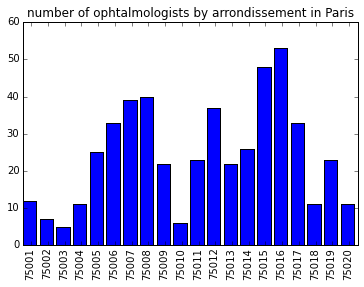

In [226]:
plt.bar(np.arange(len(n)), n)
plt.xticks(np.arange(len(n)) + 0.5, xticks, rotation=90)
plt.title("number of ophtalmologists by arrondissement in Paris")

# Extracting ophtalmologists for given cities 

In [228]:
communes = ["59910", "59166", "59560", "59170", "59510", "59250", "59510", "59390", "59115", 
            "59126", "59390", "59420", "59960", "59223", "59100", "59390", "59390", "59200", 
            "59290", "59150", "59117", "59780"]

In [230]:
df = pd.DataFrame([extract_information(doc) for doc in doctors], columns=['Nom', u'Adresse', u"Téléphone", u"Honoraires", "Convention"])

In [232]:
df['Commune'] = pd.Series(['51111'] * df.shape[0] , index=df.index)

In [233]:
df

,Nom,Adresse,Téléphone,Honoraires,Convention,Commune
0,DRYLEWICZ JOEL,87 RUE DE GERGOVIE 75014 PARIS,01 45 45 32 12,Honoraires sans dépassement,Conventionné secteur 1,51111
1,BOUMENDIL JULIEN,142 BOULEVARD DU MONTPARNASSE 75014 PARIS,01 43 20 91 75,Honoraires libres,Conventionné secteur 2,51111
2,SARFATI ADRIEN,10 RUE DAGUERRE 75014 PARIS,01 43 35 41 03,Honoraires libres,Conventionné secteur 2,51111
3,PIETRINI DOMINIQUE,SARL SARRETTE 29 RUE SARRETTE 75014 PARIS,01 56 53 58 58,Honoraires libres,Conventionné secteur 2,51111
4,TAZARTES MICHEL,142 BOULEVARD DU MONTPARNASSE 75014 PARIS,01 43 20 91 75,Honoraires libres,Conventionné secteur 2,51111
5,MONNET DOMINIQUE,HOPITAL COCHIN 27 RUE DU FBG SAINT JACQUES 750...,01 58 41 21 91,Honoraires libres,Conventionné secteur 2,51111


In [245]:
dfs = []
for city in communes:
    df = make_query("ophtalmologiste", city)
    if df is not None:
        df['Commune'] = pd.Series([city] * df.shape[0] , index=df.index)
        dfs.append(df)

In [254]:
df = pd.concat(dfs)
df = df.set_index('Commune')
df

,Nom,Adresse,Téléphone,Honoraires,Convention
Commune,,,,,
59170,DRUMARE BOUVET ISABELLE,CABINET DU DR ISABELLE DRUMARE BOUVET 6 RUE HE...,03 20 98 26 14,Honoraires avec dépassements maîtrisés (contra...,Conventionné secteur 1 avec contrat d'accès au...
59170,DUMORTIER DOMINIQUE,CABINET DU DR DOMINIQUE MARTIN 6 RUE HENRI GHE...,03 20 98 26 14,Honoraires sans dépassement,Conventionné secteur 1
59170,GUILLEMOT ODILE,CABINET DU DR ODILE GUILLEMOT BOUTET 6 RUE HEN...,03 20 98 26 14,Honoraires sans dépassement,Conventionné secteur 1
59170,KARKOUTLY REZVOY CELINE,CLINIQUE DU PARC CROIX CLINIQUE DU PARC 34 AVE...,03 20 99 41 41,Honoraires libres,Conventionné secteur 2
59100,GEVART FREDERIC,CABINE DU DR CELINE KARKOUTLY PARC DES 7 LIEUE...,Honoraires libres,Conventionné secteur 2,None
59100,GEVART FREDERIC,CABINET DU DR CHRISTIAN DOUCET 72 RUE DU COQ F...,Honoraires libres,Conventionné secteur 2,None
59100,GEVART FREDERIC,CABINET DU DR OLIVIER LAFFINEUR 72 RUE DU COQ ...,Honoraires libres,Conventionné secteur 2,None
59100,GEVART FREDERIC,SELARL DIDIER MOUTON 72 RUE DU COQ FRANCAIS 59...,03 20 70 59 29,Honoraires libres,Conventionné secteur 2
59100,MOUTON DIDIER,SELARL DIDIER MOUTON 72 RUE DU COQ FRANCAIS 59...,03 20 70 59 29,Honoraires libres,Conventionné secteur 2


In [255]:
df.to_csv("files/ophtalmologistes_59.csv", encoding='utf-8')